In [282]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


In [2]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality, option_type = "put"):
    """
    Function to calculate the price of the option using Black Scholes model

    Args:
        current_stock_price : Current stock price
        strike_price : Strike price
        current_time : Current time
        maturity_time : Maturity time
        interest_rate :  Risk free interest rate
        volatality : Volatality of the stock

    Returns:
        Option_price : Price of the option at current time
        delta : Delta value of the option
    """
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    if option_type == "put":
        option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
        delta = - norm.cdf(-d1)
    if option_type == "call":
        option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
        delta = norm.cdf(d1)
    
    
    return option_price, delta 

In [ ]:
def create_tridiagonal_matrix(main_diag_value, off_diag_value, size):
    """
    Create a tridiagonal matrix with specified values on the main diagonal and off-diagonals.
    
    Parameters:
        main_diag_value: Value of the main diagonal elements.
        off_diag_value: Value of the off-diagonal elements.
        size (int): Size of the square matrix.
    
    Returns:
        numpy.ndarray: Tridiagonal matrix.
    """
    # Create a zero-filled matrix of the specified size
    tridiag_matrix = np.zeros((size, size))
    
    # Fill the main diagonal
    np.fill_diagonal(tridiag_matrix, main_diag_value)
    
    # Fill the upper diagonal (above the main diagonal)
    np.fill_diagonal(tridiag_matrix[1:], off_diag_value[0])
    
    # Fill the lower diagonal (below the main diagonal)
    np.fill_diagonal(tridiag_matrix[:, 1:], off_diag_value[1])
    
    return tridiag_matrix

In [231]:
r = 0.04
vol = 0.3 
S0 = 100 
K = 110
T = 1
blackScholes(110, K, 0, T, r, vol, option_type = "call")

(15.128591111967928, 0.6115393362947339)

In [319]:
def euroOption_FTCS(delta_X, S0, K, vol, r, T):
    
    delta_T = delta_X ** 2 / 4
    N = int(1/delta_X)
    N_T = int(T/delta_T)
    Smax = 2 * K # arbitrary choice
    Smin = 80 # assuming stock price can't go below 0.0001, set at small number to avoid log(0) errors
    xmax = np.log(Smax)
    xmin = np.log(Smin)
    x = np.linspace(xmin, xmax, N)
    initial_option_price = np.maximum(np.exp(x) - K, 0)
    
    a = 1 - vol**2 * delta_T / ( delta_X**2)
    b = (r - 0.5 * vol**2) * delta_T / (2 * delta_X) + 0.5 * vol**2 * delta_T / (delta_X**2)
    c = - (r - 0.5 * vol**2) * delta_T / (2 * delta_X) + 0.5 * vol**2 * delta_T / (delta_X**2)
    
    dirichlet = np.zeros(N) 
    dirichlet[-1] = np.exp(xmax) - K * np.exp(-r * T)
    band_mat = create_tridiagonal_matrix(a, [b, c], N)
    prev_sol = dirichlet * b + np.dot(band_mat, initial_option_price)
    for _ in range(N_T):
        next_sol = dirichlet * b + np.dot(band_mat, prev_sol)
        prev_sol = next_sol
    
    return  np.interp(np.log(S0), x, prev_sol)

In [330]:
deltaTs = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
option_price = []
for delta_T in deltaTs:
    y = euroOption_FTCS(delta_T, 110, 110, 0.3, 0.04, 1.0)
    option_price.append(y)

Text(0, 0.5, 'Error')

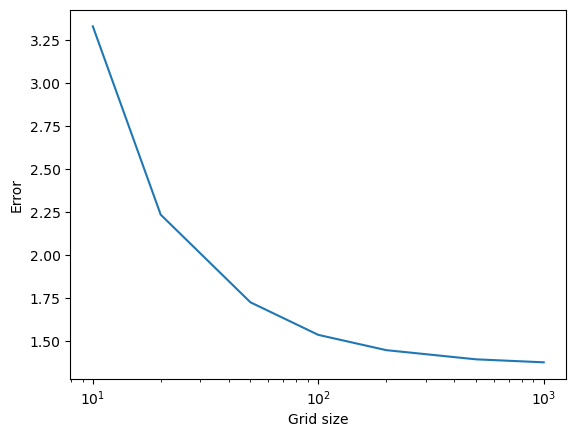

In [338]:
plt.plot(1/np.array(deltaTs), option_price-blackScholes(110, 110, 0, 1, 0.04, 0.3, option_type = "call")[0])
plt.xscale('log')
plt.xlabel("Grid size")
plt.ylabel("Error")


### COS Method

In [339]:
def function_Fn(n, r, b, a, vol, x, T):
    first_term = np.exp(-0.5 * T * (vol * n * np.pi/(b-a))**2)
    sec_term = np.cos((n * np.pi /(b - a)) * (x - a + (r - 0.5 * vol**2) * T))
    return first_term * sec_term

In [340]:
def function_Gn(K, a, b, n):
    chi_prod_term = 1 / (1 + (n * np.pi / (b - a))**2)
    chi_sec =  np.exp(b) * np.cos(n * np.pi) - np.cos(n * np.pi * a /(b - a)) + np.sin(n * np.pi * a / (b - a)) * (n * np.pi / (b - a))
    chi = chi_prod_term * chi_sec
    if n == 0:
        phi = b
    else:
        phi = np.sin(n * np.pi * a / (b - a)) * (b - a) / (n * np.pi)
        
    return (chi - phi) * 2 * K/(b - a)

In [346]:
def option_price_fourier(K, r, vol, T, a, b, N, x):
    option_price = function_Gn(K, a, b, 0) * function_Fn(0, r, b, a, vol, x, T) * 0.5
    for n in range(1, N):
        option_price += function_Gn(K, a, b, n) * function_Fn(n, r, b, a, vol, x, T)
    return option_price * np.exp(-r * T)


In [365]:
# truncation domain
S0 = 120
K = 110
x = np.log(S0/K)
a = 0.0 - 7 * np.sqrt(T)
b = 0.0 + 7 * np.sqrt(T)
option_price_fourier(K, r, vol, T, a, b, 64, x)

21.783607367825766